In [1]:
import json
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Load the datas and transform them into pd.Dataframe
df_dataset = pd.DataFrame(columns=["text", "label"])

with open("emotion_dataset.txt", "r") as datafile:
    i = 0
    for line in datafile:
        json_line = json.loads(line.strip())

        # Assert every label associated to a tweet belongs to the expected interval
        assert(0 <= json_line["label"] and json_line["label"] <= 5)

        df_dataset.loc[i] = [json_line["text"], json_line["label"]]

        i += 1


df_dataset

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
4995,i know that this pair of socks took about two ...,3
4996,i can feel the frantic beat of his heart but c...,4
4997,during lectures,1
4998,i did feel a little lighter in spirit now that...,3


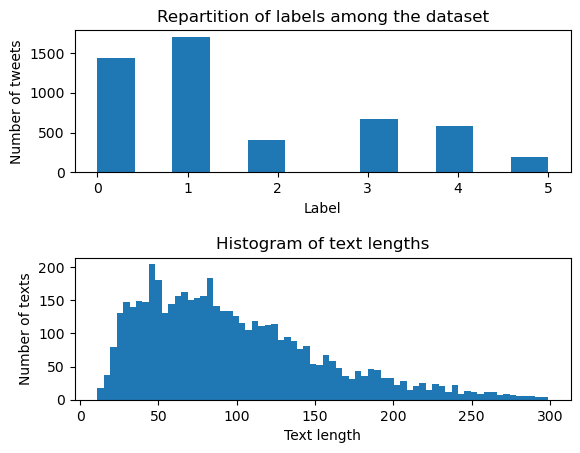

In [3]:
# Some funny plots
plt.figure()

plt.subplot(2,1,1)
plt.hist(df_dataset["label"].values, bins=12)
plt.xlabel("Label")
plt.ylabel("Number of tweets")
plt.title("Repartition of labels among the dataset")

plt.subplot(2,1,2)
plt.hist([len(text) for text in df_dataset["text"].values], bins=70)
plt.xlabel("Text length")
plt.ylabel("Number of texts")
plt.title("Histogram of text lengths")

plt.subplots_adjust(hspace=0.6)

plt.show()

In [4]:
if 0:
    # Transform the datas into suitable format for machine learning
    nlp = spacy.load("en_core_web_sm")
    lemmatized_texts = []

    for index, row in df_dataset.iterrows():
        text = row["text"]

        # Sentence lemmatization
        doc = nlp(text)
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))

    df_dataset["lemmatized_text"] = lemmatized_texts
    df_dataset.to_csv("df_emotion_dataset.csv", index=False)

In [5]:
# Open the previously created dataset with lemmatized tweets
df_dataset = pd.read_csv("df_emotion_dataset.csv")

x = df_dataset["lemmatized_text"]
y = df_dataset["label"]

# Create a CountVectorizer Object
vectorizer = CountVectorizer()

# Fit and transform the corpus with bag of word method
x = vectorizer.fit_transform(x)

# Split the dataset into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=12)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [7]:
# Majority classifier (copied from lab5)
predicted_labels = [y_train.value_counts().idxmax()]*len(y_test)
accuracy_majority = accuracy_score(y_test, predicted_labels)
print("Majority classifier Accuracy:", accuracy_majority)

Majority classifier Accuracy: 0.32


In [8]:
# KNN
acc = []
for i in range(5,100,5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    predicted_knn = knn.predict(X_test)
    accuracy_knn = accuracy_score(y_test, predicted_knn)
    # print("KNN Accuracy:", accuracy_knn)
    acc.append(accuracy_knn)

print(f"Best acc is {np.max(acc)} for number of neibhors = {5 + np.argmax(acc)*5}.")
knn = KNeighborsClassifier(n_neighbors=15)

Best acc is 0.364 for number of neibhors = 15.


In [9]:
# Decision Trees
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
dec_tree_pred = dec_tree.predict(X_test)
dec_tree_acc = accuracy_score(y_test, dec_tree_pred)
print("Decision Tree Accuracy:", dec_tree_acc)

Decision Tree Accuracy: 0.7376


In [10]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predicted_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7176


In [11]:
# Bagging
model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20, random_state=42)
model_bagging.fit(X_train, y_train)
pred_bagging = model_bagging.predict(X_test)
result_bagging = accuracy_score(y_test, pred_bagging)
print("Bagging Accuracy:", result_bagging)

Bagging Accuracy: 0.7384


In [46]:
# Boosting
model_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
model_boosting.fit(X_train, y_train)
pred_boosting = model_boosting.predict(X_test)
result_boosting = accuracy_score(y_test, pred_boosting)
print("Boosting Accuracy:", result_boosting)

/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Boosting Accuracy: 0.7712


In [19]:
def cross_validation_eval(X_train, y_train, classifier, folds=5):
    """
    Test an already trained model using the cross validation pipeline.
    
    Parameters:
    X_train : the training datas without labels
    y_train : the labels of the training datas
    classifier : the model we want to evaluate
    folds : number of subgroups in which we divide the training dataset 

    """
    # Create a copy of training data
    X_cv = X_train.copy()
    y_cv = y_train.copy()

    # Initialize variables to store fold-specific evaluation metrics
    fold_eval = []

    # Initialize k-fold cross-validation
    # This implementation (*Stratified*KFolds) respects the class proportion among each folds
    skfolds = StratifiedKFold(n_splits=folds, shuffle=True)

    for _, (train_index, test_index) in enumerate(skfolds.split(X_cv, y_cv)):
        # Select data from train and test based on indices provided by kfold
        X_cv_train, X_cv_test = X_cv[train_index], X_cv[test_index]
        y_cv_train, y_cv_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

        # Train the classifier
        classifier.fit(X_cv_train, y_cv_train)

        # Predict on the test set
        y_cv_pred = classifier.predict(X_cv_test)

        # Compute the accuracy metric for this fold
        accuracy = accuracy_score(y_cv_test, y_cv_pred)
        fold_eval.append(accuracy)

    # Calculate the mean performance across all folds for this k
    mean_accuracy = np.mean(fold_eval)

    return mean_accuracy

In [13]:
print("The average score of Decision Tree model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, knn))
print("The average score of Decision Tree model for cross validation evaluation is :", cross_validation_eval(X_train, y_train, dec_tree))

The average score of Decision Tree model for cross validation evaluation is : 0.3452924407248915
The average score of Decision Tree model for cross validation evaluation is : 0.7162038646549054


In [14]:
def hyperparameter_tuning(X_train, y_train, model, parameters_range):
    """
    Hyperparameter tuning using Grid Search
    (méchamment pompé du lab5)
    
    Parameters:
    X_train : the training datas unlabeled
    y_train : the corresponding labels
    model : the model we want to tune the parameters
    parameters_range (dict) : range of possible value for parameter n_neighbors

    Return:
    best_model : the model trained with the best set of parameters
    best_val : the corresponding values that train the model best
    """
    grid_search = GridSearchCV(model, parameters_range, cv=3, verbose=3) # cv = cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best model and corresponding values
    best_model = grid_search.best_estimator_
    best_val = {}
    for param in parameters_range.keys():
        best_val[param] = grid_search.best_params_[param]

    return best_model, best_val

In [15]:
parame = {"splitter" : ["best", "random"], "max_depth": list(range(10,30))}
print(hyperparameter_tuning(X_train, y_train, DecisionTreeClassifier(), parame)[1])

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END .......max_depth=10, splitter=best;, score=0.375 total time=   0.0s
[CV 2/3] END .......max_depth=10, splitter=best;, score=0.388 total time=   0.0s
[CV 3/3] END .......max_depth=10, splitter=best;, score=0.377 total time=   0.0s
[CV 1/3] END .....max_depth=10, splitter=random;, score=0.377 total time=   0.0s
[CV 2/3] END .....max_depth=10, splitter=random;, score=0.396 total time=   0.0s
[CV 3/3] END .....max_depth=10, splitter=random;, score=0.377 total time=   0.0s
[CV 1/3] END .......max_depth=11, splitter=best;, score=0.383 total time=   0.0s
[CV 2/3] END .......max_depth=11, splitter=best;, score=0.396 total time=   0.0s
[CV 3/3] END .......max_depth=11, splitter=best;, score=0.380 total time=   0.0s
[CV 1/3] END .....max_depth=11, splitter=random;, score=0.387 total time=   0.0s
[CV 2/3] END .....max_depth=11, splitter=random;, score=0.399 total time=   0.0s
[CV 3/3] END .....max_depth=11, splitter=random

## Neural network in pytorch using pretrained embeddings with the hugging face librairie

In [37]:
from datasets import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch

class EmotionDataLoader:
    def __init__(self, csv_path, model_name='all-MiniLM-L6-v2', batch_size=16):
        """
        Initialize the data loader with a more sophisticated embedding model.
        
        Args:
            csv_path: Path to the CSV file containing text and labels
            model_name: SentenceTransformer model to use for embeddings
            batch_size: Batch size for DataLoader
        """
        self.csv_path = csv_path
        self.batch_size = batch_size
        # Initialize the sentence transformer model
        self.embedding_model = SentenceTransformer(model_name)
        # Set embedding dimension based on model
        self.embedding_dim = self.embedding_model.get_sentence_embedding_dimension()
        
    def load_data(self):
        """Load and split the data"""
        df = pd.read_csv(self.csv_path)
        train_df, val_df = train_test_split(
            df, 
            test_size=0.2, 
            random_state=42, 
            stratify=df['label']
        )
        return train_df, val_df
    
    def generate_embeddings(self, texts):
        """
        Generate embeddings for a list of texts using SentenceTransformer.
        Returns tensor of shape (n_texts, embedding_dim)
        """
        with torch.no_grad():
            embeddings = self.embedding_model.encode(
                texts,
                batch_size=self.batch_size,
                show_progress_bar=False,
                convert_to_tensor=True
            )
        return embeddings
    
    def create_dataset(self, df):
        """Create a PyTorch dataset from DataFrame with embeddings"""
        # Generate embeddings for all texts
        embeddings = self.generate_embeddings(df['text'].tolist())
        labels = torch.tensor(df['label'].values)
        
        # Create TensorDataset
        dataset = torch.utils.data.TensorDataset(embeddings, labels)
        return dataset
    
    def prepare_dataloader(self):
        """Prepare train and validation dataloaders with embeddings"""
        # Load and split data
        train_df, val_df = self.load_data()
        
        # Create datasets with embeddings
        train_dataset = self.create_dataset(train_df)
        val_dataset = self.create_dataset(val_df)
        
        # Create DataLoaders
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        return train_dataloader, val_dataloader, self.embedding_dim
    

# Initialize the data loader
loader = EmotionDataLoader(
    csv_path='df_emotion_dataset.csv',
    model_name='all-MiniLM-L6-v2',  # You can try other models too
    batch_size=16
)

# Get dataloaders and embedding dimension
train_loader, val_loader, embedding_dim = loader.prepare_dataloader()


In [29]:
import torch
import torch.nn as nn
from transformers import AutoModel

class SimpleLinearClassifier(nn.Module):
    def __init__(self, input_size=128, num_classes=6):
        super().__init__()
        self.classifier = nn.Linear(input_size, num_classes)
        
    
    def forward(self, x):
        x = x.to(torch.float32)
        return self.classifier(x)
    

class model2(nn.Module):
    def __init__(self, input_size=128, num_classes=6):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        x = x.to(torch.float32)
        return self.linear2(self.relu(self.linear1(x)))
    

class model3(nn.Module):
    def __init__(self, input_size=128, num_classes=6):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8*input_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(8*input_size, 4*input_size)
        self.final = nn.Linear(4*input_size, num_classes)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        return self.final(x)
        
    

        


In [51]:
def train(model, train_dataloader, val_dataloader, device, num_epochs=100, lr=1e-3):
    """Train the model and plot loss evoution"""
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    trainings_loss = []
    val_loss = []
    accuracy = []

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # loss on 
        trainings_loss.append(loss.item())
        print(f'Training loss: {loss.item()}')


        # validation loss and accuracy at this epoch 
        model.eval()
        val_loss_temp = []
        temp_accuracy = []
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            # Compute accuracy
            predicted = torch.argmax(outputs, dim=1)
            temp_accuracy.append((predicted == labels).sum().item() / len(labels))   
            loss = criterion(outputs, labels)
            val_loss_temp.append(loss.item())

        

        accuracy.append(np.mean(temp_accuracy))
        val_loss.append(np.mean(val_loss_temp))
        print(f'Validation loss: {np.mean(val_loss_temp)}')
        print(f'Validation accuracy: {np.mean(temp_accuracy)}')

    
    # plot loss evolution (validation and training)
    plt.plot(trainings_loss)
    plt.plot(val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss evolution')
    plt.legend(['Training', 'Validation'])

    #plot accuracy evolution
    plt.figure()
    plt.plot(accuracy)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution')

    return accuracy[-1]



In [19]:
def extract_csv_fraction(input_file, output_file, fraction=0.10, random=True):
    """
    Extract a fraction of rows from a CSV file and save it to a new file.

    Parameters:
        input_file (str): Path to the input CSV file.
        output_file (str): Path to save the reduced CSV file.
        fraction (float): Fraction of rows to extract (default is 10%).
        random (bool): Whether to sample rows randomly (default is True).
    """
    # Load the CSV file
    print(f"Loading the CSV file: {input_file}")
    data = pd.read_csv(input_file)
    
    # Extract a fraction of the data
    if random:
        sampled_data = data.sample(frac=fraction, random_state=42)  # Random sampling
    else:
        sampled_data = data.head(int(len(data) * fraction))  # Take top rows
    
    # drop the column unmaed
    sampled_data = sampled_data.drop(columns=sampled_data.columns[0])
    # Save the sampled data to a new file
    sampled_data.to_csv(output_file, index=False)
    print(f"Saved {fraction*100}% of the data to: {output_file}")

# Example usage:
# extract_csv_fraction("large_dataset.csv", "reduced_dataset.csv", fraction=0.10, random=True)

extract_csv_fraction("text.csv", "reduced_text.csv", fraction=0.10, random=True)


Loading the CSV file: text.csv
Saved 10.0% of the data to: reduced_text.csv


Epoch 1/10
Training loss: 1.45538330078125
Validation loss: 1.16189300919336
Validation accuracy: 0.5922619047619048
Epoch 2/10
Training loss: 0.7607305645942688
Validation loss: 1.0184742429899791
Validation accuracy: 0.6369047619047619
Epoch 3/10
Training loss: 0.6288830041885376
Validation loss: 0.9887338905107408
Validation accuracy: 0.6388888888888888
Epoch 4/10
Training loss: 0.7633376717567444
Validation loss: 0.9608248836464353
Validation accuracy: 0.6517857142857143
Epoch 5/10
Training loss: 0.4048638939857483
Validation loss: 0.9466371167273748
Validation accuracy: 0.6498015873015873
Epoch 6/10
Training loss: 0.5598477721214294
Validation loss: 0.9370820725721026
Validation accuracy: 0.6498015873015873
Epoch 7/10
Training loss: 0.7262908220291138
Validation loss: 0.9428413515053098
Validation accuracy: 0.6498015873015873
Epoch 8/10
Training loss: 0.16756275296211243
Validation loss: 0.9518201464698428
Validation accuracy: 0.6636904761904762
Epoch 9/10
Training loss: 0.5859833

0.6547619047619048

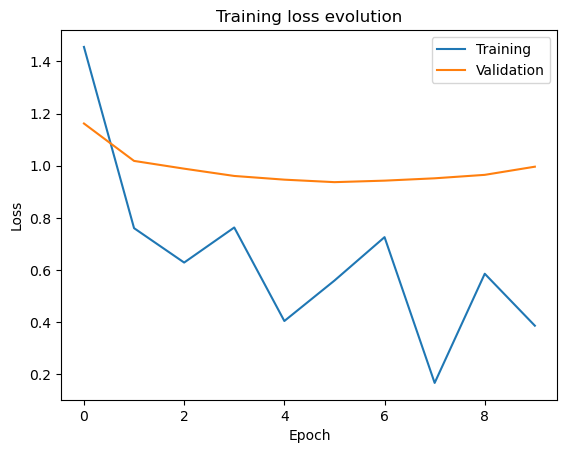

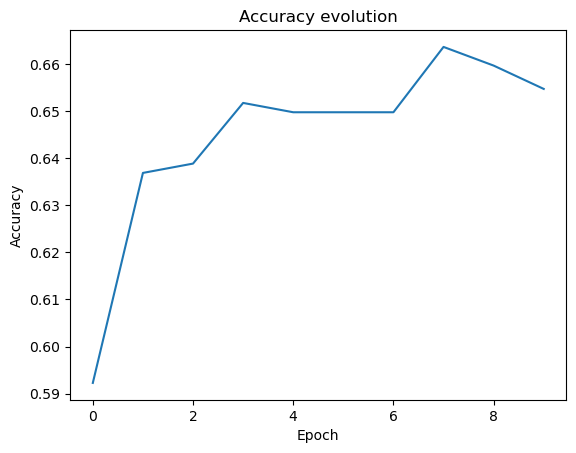

In [52]:
#Putting all together
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# Load the data
data_loader = EmotionDataLoader(
    csv_path='df_emotion_dataset.csv',
    model_name='all-MiniLM-L6-v2',  # You can try other models too
    batch_size=16
)
train_dataloader, val_dataloader, emb_size = data_loader.prepare_dataloader()

# Create the model
model = model3(input_size=emb_size, num_classes=6)
model.to(device)

# Train the model
train(model, train_dataloader, val_dataloader, num_epochs=10, lr=1e-4, device=device)


In [61]:
def use_with_example(model, sentence, data_loader = data_loader ):
    """Use the model to predict the emotion of a sentence"""
    # Tokenize the input sentence
    inputs = data_loader.generate_embeddings([sentence])
    inputs = inputs.to(device)
    model.eval()
    # Get the model prediction
    with torch.no_grad(): 
        outputs = model(inputs)

    print(outputs)
    print(outputs.shape)
    predicted = torch.argmax(outputs, dim=1)
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    return emotions[predicted.item()]


use_with_example(model, "I am in love with her" )

  

tensor([[-2.1791,  1.0138, -0.1117,  0.1213, -1.1586, -2.1756]],
       device='mps:0')
torch.Size([1, 6])


'joy'